# ⚠️ Auto-generated Notebook
    
This notebook is automatically compiled from source files in `/workspaces/awesome-matrix/src/examples/11_tensor_operations_einsum`.
**Do not edit this file directly** as your changes will be overwritten.

To make changes:
1. Edit the source file `/workspaces/awesome-matrix/src/examples/11_tensor_operations_einsum/03_applications.py` instead
2. Run the compile script to regenerate this notebook

See [COMPILE.md](docs/COMPILE.md) for more information.


# Applications of Tensor Operations and Einstein Notation

In this notebook, we'll explore practical applications of tensor operations and Einstein notation across various fields. Understanding how these mathematical tools are used in real-world problems helps develop intuition for working with tensors in any domain.

We'll cover the following applications:

1. Machine Learning - Implementing a simple neural network layer
2. Computer Graphics - 3D transformations and projections
3. Physics - Moment of inertia calculations
4. Signal Processing - Image filtering and convolutions
5. Natural Language Processing - Word embeddings and attention mechanisms


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the style for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")


## 1. Machine Learning: Neural Network Layers

Tensor operations are fundamental to deep learning. Let's implement some basic neural network components using Einstein notation.


### Dense (Fully Connected) Layer

A dense layer applies a linear transformation followed by a non-linear activation:

$y = \sigma(Wx + b)$

Where:
- $W$ is the weight matrix
- $x$ is the input vector
- $b$ is the bias vector
- $\sigma$ is an activation function


In [2]:
# Define a simple dense layer
class EinsumDense:
    def __init__(self, input_dim, output_dim, activation=None):
        # Initialize weights and biases
        self.weights = torch.randn(input_dim, output_dim) * 0.1
        self.bias = torch.zeros(output_dim)
        self.activation = activation
    
    def forward(self, x):
        # Linear transformation using einsum
        # Batch of inputs: shape (batch_size, input_dim)
        # Weights: shape (input_dim, output_dim)
        # Output: shape (batch_size, output_dim)
        out = torch.einsum('bi,io->bo', x, self.weights) + self.bias
        
        # Apply activation if provided
        if self.activation == 'relu':
            out = torch.relu(out)
        elif self.activation == 'sigmoid':
            out = torch.sigmoid(out)
        
        return out


Let's test our implementation with some dummy data:


Input shape: torch.Size([4, 5])
Output shape: torch.Size([4, 3])
Output values:
 tensor([[0.0531, 0.0000, 0.2191],
        [0.2953, 0.0000, 0.0000],
        [0.0000, 0.1528, 0.0147],
        [0.6373, 0.0000, 0.0000]])


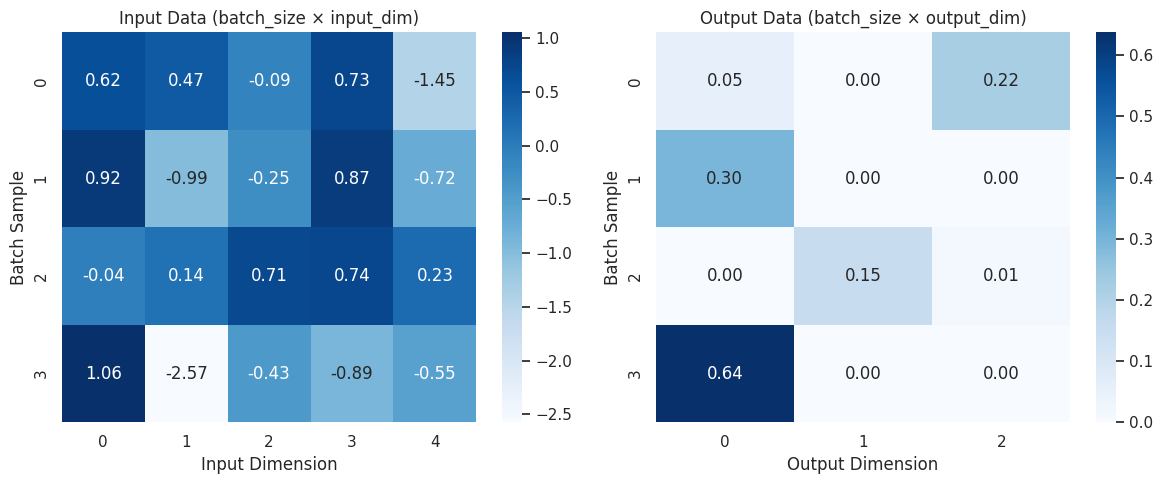

In [3]:
# Create batch of input data
batch_size = 4
input_dim = 5
output_dim = 3

# Create random input data
inputs = torch.randn(batch_size, input_dim)
print("Input shape:", inputs.shape)

# Create our layer
dense_layer = EinsumDense(input_dim, output_dim, activation='relu')

# Forward pass
outputs = dense_layer.forward(inputs)
print("Output shape:", outputs.shape)
print("Output values:\n", outputs)

# Visualize the transformation
plt.figure(figsize=(12, 5))

# Input visualization
plt.subplot(121)
sns.heatmap(inputs.detach().numpy(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Input Data (batch_size × input_dim)')
plt.xlabel('Input Dimension')
plt.ylabel('Batch Sample')

# Output visualization
plt.subplot(122)
sns.heatmap(outputs.detach().numpy(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Output Data (batch_size × output_dim)')
plt.xlabel('Output Dimension')
plt.ylabel('Batch Sample')

plt.tight_layout()
plt.show()


### Multi-Head Attention Layer

Multi-head attention is a key component of transformer models. Let's implement a simplified version using einstein notation:


In [4]:
class EinsumMultiHeadAttention:
    def __init__(self, d_model, num_heads):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        
        # Initialize projection matrices
        self.W_q = torch.randn(d_model, d_model) * 0.1
        self.W_k = torch.randn(d_model, d_model) * 0.1
        self.W_v = torch.randn(d_model, d_model) * 0.1
        self.W_o = torch.randn(d_model, d_model) * 0.1
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        # Project inputs to queries, keys, and values
        # Shape: (batch, seq_len, d_model)
        Q = torch.einsum('bsi,ij->bsj', query, self.W_q)
        K = torch.einsum('bti,ij->btj', key, self.W_k)
        V = torch.einsum('bti,ij->btj', value, self.W_v)
        
        # Reshape for multi-head attention
        # Shape: (batch, num_heads, seq_len, d_head)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)
        
        # Calculate attention scores
        # Shape: (batch, num_heads, seq_len_q, seq_len_k)
        attention_scores = torch.einsum('bhsd,bhtd->bhst', Q, K) / (self.d_head ** 0.5)
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Apply attention weights to values
        # Shape: (batch, num_heads, seq_len_q, d_head)
        attention_output = torch.einsum('bhst,bhtd->bhsd', attention_weights, V)
        
        # Reshape back
        # Shape: (batch, seq_len_q, d_model)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        # Final projection
        output = torch.einsum('bsi,ij->bsj', attention_output, self.W_o)
        
        return output, attention_weights


Input shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 2, 4, 4])


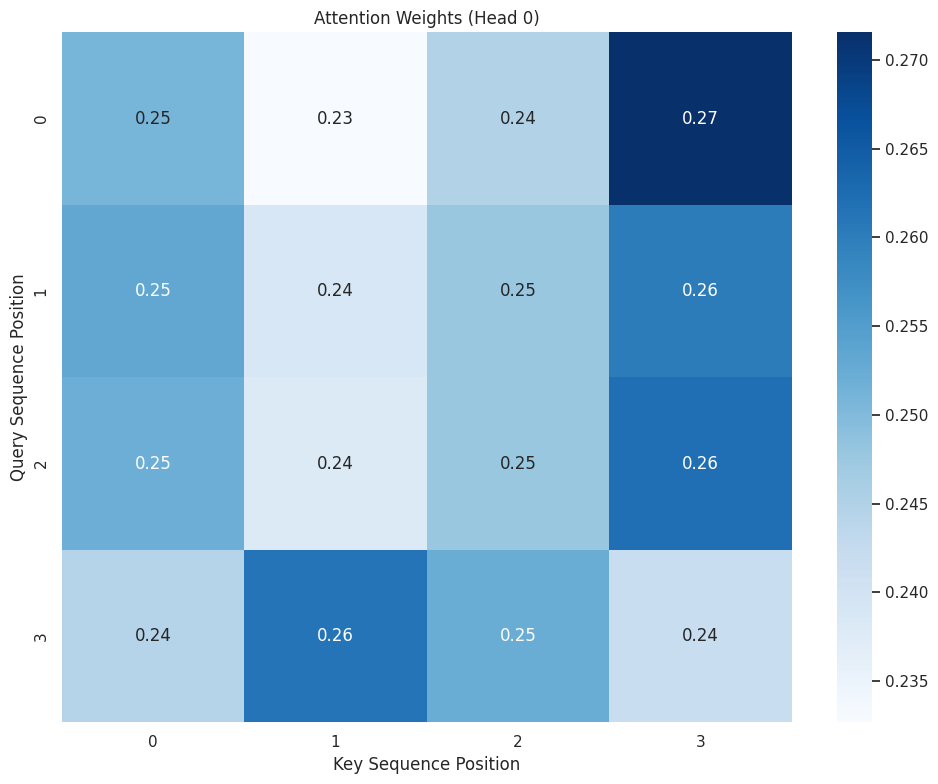

In [5]:
# Test the multi-head attention implementation
batch_size = 2
seq_len = 4
d_model = 8
num_heads = 2

# Create random input data
query = torch.randn(batch_size, seq_len, d_model)
key = torch.randn(batch_size, seq_len, d_model)
value = torch.randn(batch_size, seq_len, d_model)

# Create multi-head attention layer
mha = EinsumMultiHeadAttention(d_model, num_heads)

# Forward pass
output, attention_weights = mha.forward(query, key, value)

print("Input shape:", query.shape)
print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

# Visualize attention weights for one head
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[0, 0].detach().numpy(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Attention Weights (Head 0)')
plt.xlabel('Key Sequence Position')
plt.ylabel('Query Sequence Position')
plt.tight_layout()
plt.show()


## 2. Computer Graphics: 3D Transformations

Tensor operations are fundamental in computer graphics for transforming objects in 3D space. Let's explore some applications.


### Homogeneous Coordinates and Transformation Matrices

In 3D computer graphics, points are often represented in homogeneous coordinates to enable affine transformations using matrix multiplication. Let's implement some basic transformations:


In [6]:
def create_translation_matrix(tx, ty, tz):
    """Create a 4x4 translation matrix for 3D homogeneous coordinates."""
    return torch.tensor([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ], dtype=torch.float32)

def create_rotation_matrix_z(angle_degrees):
    """Create a 4x4 rotation matrix around the Z axis."""
    angle_rad = torch.tensor(angle_degrees * np.pi / 180)
    cos_a = torch.cos(angle_rad)
    sin_a = torch.sin(angle_rad)
    
    return torch.tensor([
        [cos_a, -sin_a, 0, 0],
        [sin_a, cos_a, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)

def create_scaling_matrix(sx, sy, sz):
    """Create a 4x4 scaling matrix."""
    return torch.tensor([
        [sx, 0, 0, 0],
        [0, sy, 0, 0],
        [0, 0, sz, 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)


Let's create a simple 3D cube and apply some transformations:


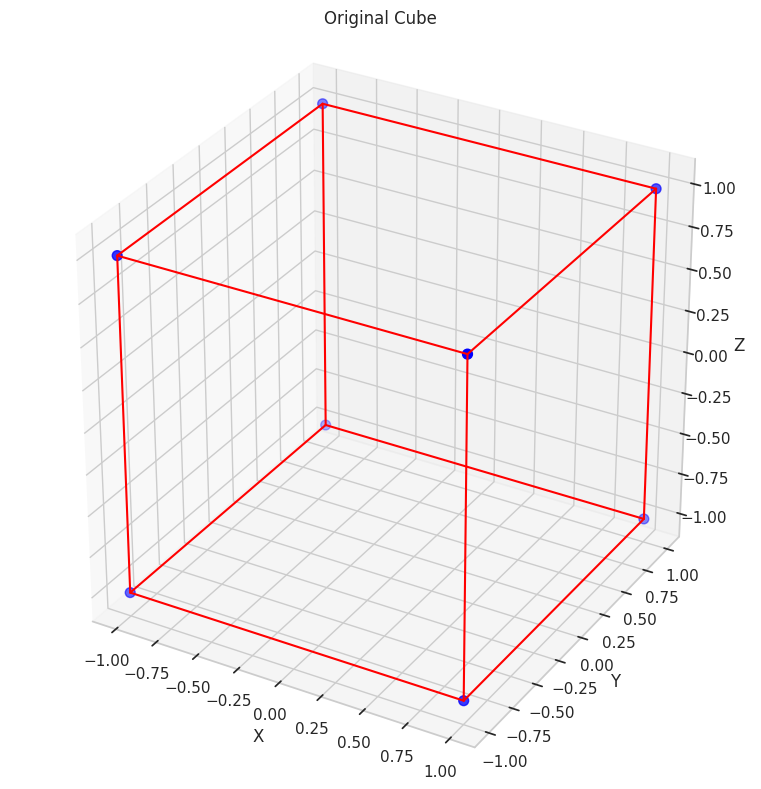

In [7]:
# Define a cube with 8 vertices in homogeneous coordinates
# Each vertex is [x, y, z, 1]
cube_vertices = torch.tensor([
    [-1, -1, -1, 1],  # 0: bottom-back-left
    [1, -1, -1, 1],   # 1: bottom-back-right
    [1, 1, -1, 1],    # 2: bottom-front-right
    [-1, 1, -1, 1],   # 3: bottom-front-left
    [-1, -1, 1, 1],   # 4: top-back-left
    [1, -1, 1, 1],    # 5: top-back-right
    [1, 1, 1, 1],     # 6: top-front-right
    [-1, 1, 1, 1],    # 7: top-front-left
], dtype=torch.float32)

# Define cube edges for plotting (pairs of vertex indices)
cube_edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
    (0, 4), (1, 5), (2, 6), (3, 7)   # Connecting edges
]

# Create a function to visualize the cube
def plot_cube(vertices, edges, title="Cube"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
               color='blue', s=50, label='Vertices')
    
    # Plot edges
    for edge in edges:
        ax.plot([vertices[edge[0], 0], vertices[edge[1], 0]],
                [vertices[edge[0], 1], vertices[edge[1], 1]],
                [vertices[edge[0], 2], vertices[edge[1], 2]],
                color='red')
    
    # Set axis limits and labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.tight_layout()
    plt.show()

# Plot the original cube
plot_cube(cube_vertices[:, :3], cube_edges, "Original Cube")


Now let's apply a series of transformations to our cube and visualize the result:


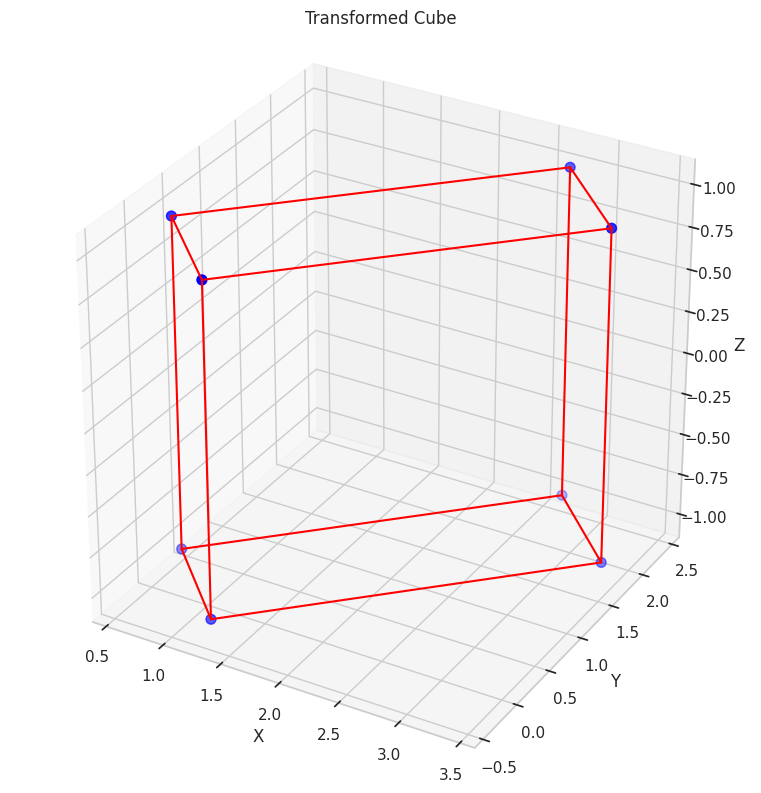

In [8]:
# Create transformation matrices
translation = create_translation_matrix(2, 1, 0)
rotation = create_rotation_matrix_z(45)
scaling = create_scaling_matrix(1.5, 0.5, 1)

# Combine transformations (order matters: first scale, then rotate, then translate)
# Using einsum to perform the matrix multiplications
combined_transform = torch.einsum('ij,jk->ik', 
                                 torch.einsum('ij,jk->ik', translation, rotation), 
                                 scaling)

# Apply transformation to cube vertices using einsum
# vertices_shape: (8, 4), transform_shape: (4, 4), output_shape: (8, 4)
transformed_vertices = torch.einsum('ij,kj->ki', combined_transform, cube_vertices)

# Plot the transformed cube
plot_cube(transformed_vertices[:, :3], cube_edges, "Transformed Cube")


### Perspective Projection

Let's implement a perspective projection to convert our 3D cube into a 2D view:


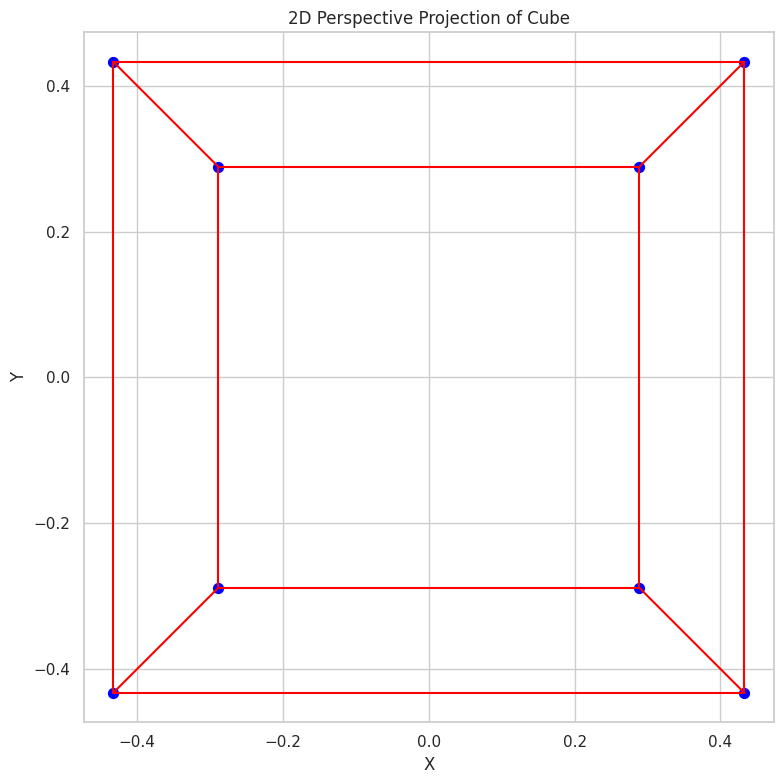

In [9]:
def create_perspective_matrix(fov_degrees, aspect_ratio, near, far):
    """Create a perspective projection matrix."""
    fov_rad = torch.tensor(fov_degrees * np.pi / 180)
    f = 1.0 / torch.tan(fov_rad / 2)
    
    return torch.tensor([
        [f / aspect_ratio, 0, 0, 0],
        [0, f, 0, 0],
        [0, 0, (far + near) / (near - far), (2 * far * near) / (near - far)],
        [0, 0, -1, 0]
    ], dtype=torch.float32)

# Create a perspective projection matrix
perspective = create_perspective_matrix(60, 1.0, 0.1, 100)

# Position the cube in front of the camera
view_transform = create_translation_matrix(0, 0, -5)
positioned_vertices = torch.einsum('ij,kj->ki', view_transform, cube_vertices)

# Apply perspective projection
projected_vertices = torch.einsum('ij,kj->ki', perspective, positioned_vertices)

# Convert from homogeneous to Euclidean coordinates (divide by w)
w = projected_vertices[:, 3].reshape(-1, 1)
projected_vertices_2d = projected_vertices[:, :3] / w

# Plot the 2D projection
plt.figure(figsize=(8, 8))
plt.scatter(projected_vertices_2d[:, 0], projected_vertices_2d[:, 1], color='blue', s=50)

# Draw edges in 2D
for edge in cube_edges:
    plt.plot([projected_vertices_2d[edge[0], 0], projected_vertices_2d[edge[1], 0]],
             [projected_vertices_2d[edge[0], 1], projected_vertices_2d[edge[1], 1]],
             color='red')

plt.title('2D Perspective Projection of Cube')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


## 3. Physics: Moment of Inertia Tensor

In physics, the moment of inertia is represented as a 3×3 tensor for a three-dimensional object. Let's compute it for a simple system of point masses:


In [10]:
# Define a system of point masses
# Each row represents [x, y, z, mass]
particles = torch.tensor([
    [1.0, 0.0, 0.0, 2.0],    # mass 2 at (1,0,0)
    [0.0, 1.0, 0.0, 3.0],    # mass 3 at (0,1,0)
    [0.0, 0.0, 1.0, 4.0],    # mass 4 at (0,0,1)
    [1.0, 1.0, 1.0, 1.0]     # mass 1 at (1,1,1)
])

# Extract positions and masses
positions = particles[:, :3]  # first 3 columns are x,y,z
masses = particles[:, 3]      # last column is mass


The moment of inertia tensor I is defined as:

$I_{ij} = \sum_p m_p (r_p^2 \delta_{ij} - r_{pi} r_{pj})$

where:
- $m_p$ is the mass of particle $p$
- $r_p$ is the distance of particle $p$ from the origin
- $r_{pi}$ is the $i$-th component of the position of particle $p$
- $\delta_{ij}$ is the Kronecker delta (1 if $i=j$, 0 otherwise)

Let's implement this calculation:


Moment of inertia tensor:
tensor([[ 9., -1., -1.],
        [-1.,  8., -1.],
        [-1., -1.,  7.]])


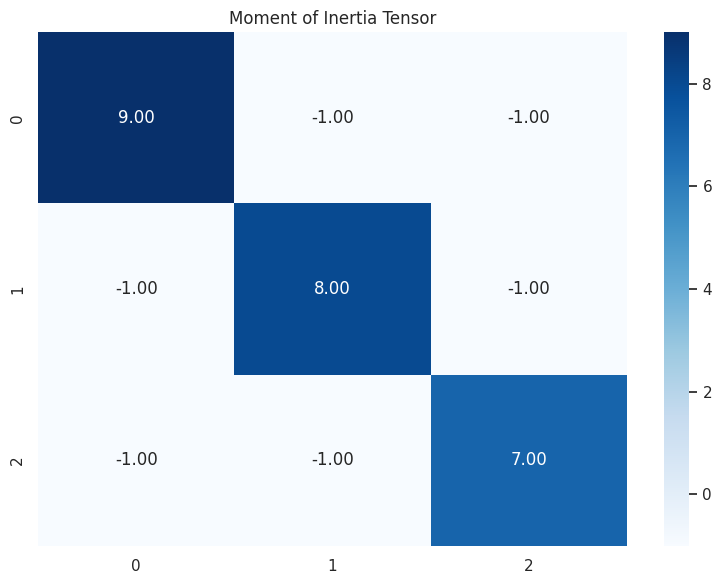

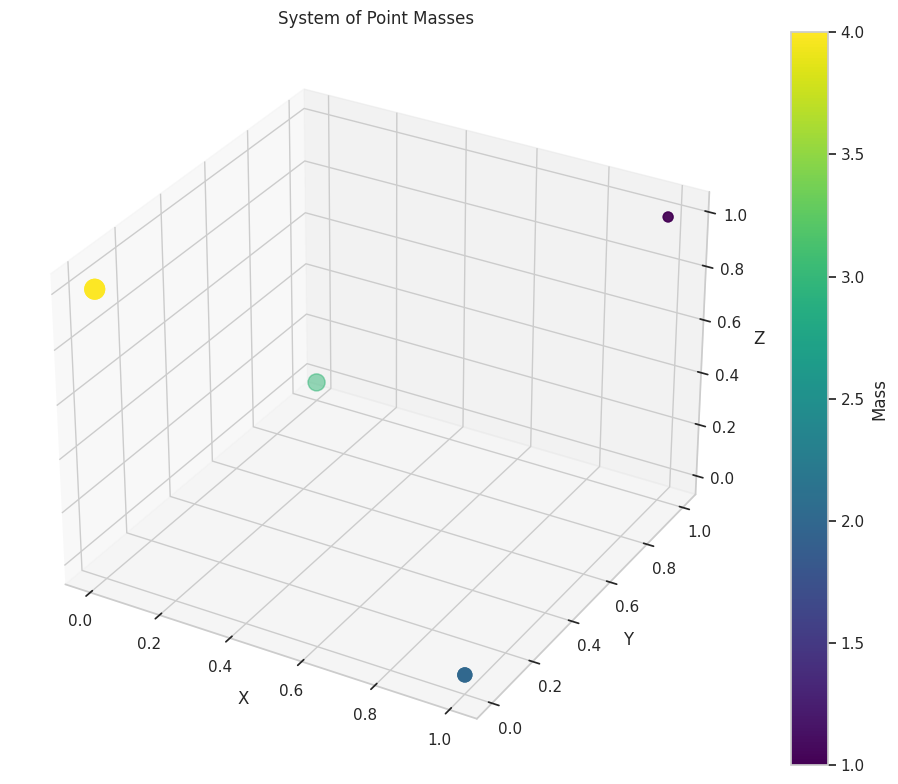

In [11]:
# Calculate r^2 for each particle
r_squared = torch.sum(positions**2, dim=1)  # Sum of x^2 + y^2 + z^2 for each particle

# Calculate the moment of inertia tensor
I = torch.zeros((3, 3))  # Initialize 3x3 tensor

# First term: sum of m_p * r_p^2 * delta_ij
for i in range(3):
    I[i, i] = torch.sum(masses * r_squared)

# Second term: -sum of m_p * r_pi * r_pj
# Using einsum to compute outer product of positions, then sum with weights
weighted_positions = torch.einsum('p,pi->pi', masses, positions)  # Multiply each position by mass
outer_products = torch.einsum('pi,pj->pij', positions, weighted_positions)  # Compute outer products
sum_outer_products = torch.sum(outer_products, dim=0)  # Sum over all particles

# Combine terms
I = I - sum_outer_products

print("Moment of inertia tensor:")
print(I)

# Visualize the moment of inertia tensor
plt.figure(figsize=(8, 6))
sns.heatmap(I.detach().numpy(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Moment of Inertia Tensor')
plt.tight_layout()
plt.show()

# Plot the point mass system in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scale point sizes based on mass
sizes = masses * 50

# Plot particles
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
           s=sizes, c=masses, cmap='viridis', label='Point Masses')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('System of Point Masses')

# Add a colorbar for mass
cbar = plt.colorbar(ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                              s=sizes, c=masses, cmap='viridis'), ax=ax)
cbar.set_label('Mass')

plt.tight_layout()
plt.show()


## 4. Signal Processing: Image Filtering

Convolution operations, which are essential for image filtering, can be expressed efficiently using einsum.


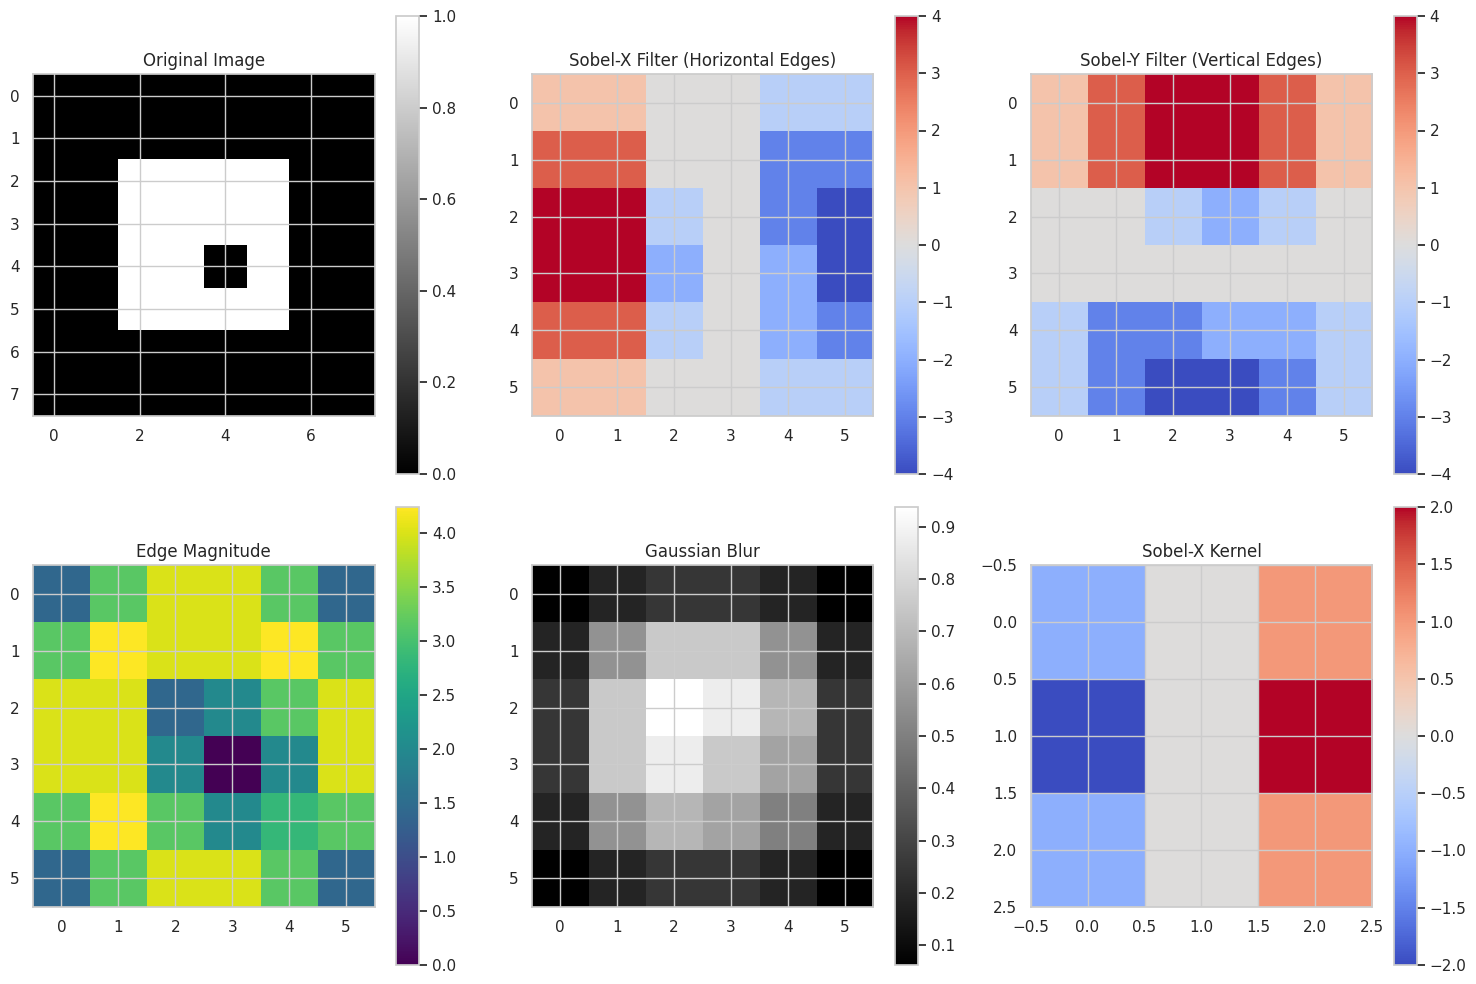

In [12]:
# Create a simple 8x8 grayscale image
image = torch.zeros((8, 8))
image[2:6, 2:6] = 1.0  # Create a white square in the middle
image[4, 4] = 0.0      # Add a black pixel in the center of the square

# Define some common image filters
sobel_x = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=torch.float32)

sobel_y = torch.tensor([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=torch.float32)

gaussian = torch.tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=torch.float32) / 16  # Normalize to sum to 1

# Define a function to apply filters using einsum
def apply_filter(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    
    # Initialize output
    output = torch.zeros((height - k_height + 1, width - k_width + 1))
    
    # Extract patches
    patches = torch.zeros((height - k_height + 1, width - k_width + 1, k_height, k_width))
    for i in range(height - k_height + 1):
        for j in range(width - k_width + 1):
            patches[i, j] = image[i:i+k_height, j:j+k_width]
    
    # Apply convolution using einsum
    output = torch.einsum('ijkl,kl->ij', patches, kernel)
    
    return output

# Apply filters to our image
filtered_sobel_x = apply_filter(image, sobel_x)
filtered_sobel_y = apply_filter(image, sobel_y)
filtered_gaussian = apply_filter(image, gaussian)

# Compute magnitude of Sobel gradients (edge detection)
edge_magnitude = torch.sqrt(filtered_sobel_x**2 + filtered_sobel_y**2)

# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
im0 = axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
plt.colorbar(im0, ax=axes[0, 0])

# Sobel-x
im1 = axes[0, 1].imshow(filtered_sobel_x, cmap='coolwarm')
axes[0, 1].set_title('Sobel-X Filter (Horizontal Edges)')
plt.colorbar(im1, ax=axes[0, 1])

# Sobel-y
im2 = axes[0, 2].imshow(filtered_sobel_y, cmap='coolwarm')
axes[0, 2].set_title('Sobel-Y Filter (Vertical Edges)')
plt.colorbar(im2, ax=axes[0, 2])

# Edge magnitude
im3 = axes[1, 0].imshow(edge_magnitude, cmap='viridis')
axes[1, 0].set_title('Edge Magnitude')
plt.colorbar(im3, ax=axes[1, 0])

# Gaussian blur
im4 = axes[1, 1].imshow(filtered_gaussian, cmap='gray')
axes[1, 1].set_title('Gaussian Blur')
plt.colorbar(im4, ax=axes[1, 1])

# Show the Sobel-X kernel
im5 = axes[1, 2].imshow(sobel_x, cmap='coolwarm')
axes[1, 2].set_title('Sobel-X Kernel')
plt.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()
plt.show()


## 5. Natural Language Processing: Word Embeddings

Word embeddings represent words as dense vectors in a continuous vector space. Let's simulate a simple word embedding system and compute word similarities:


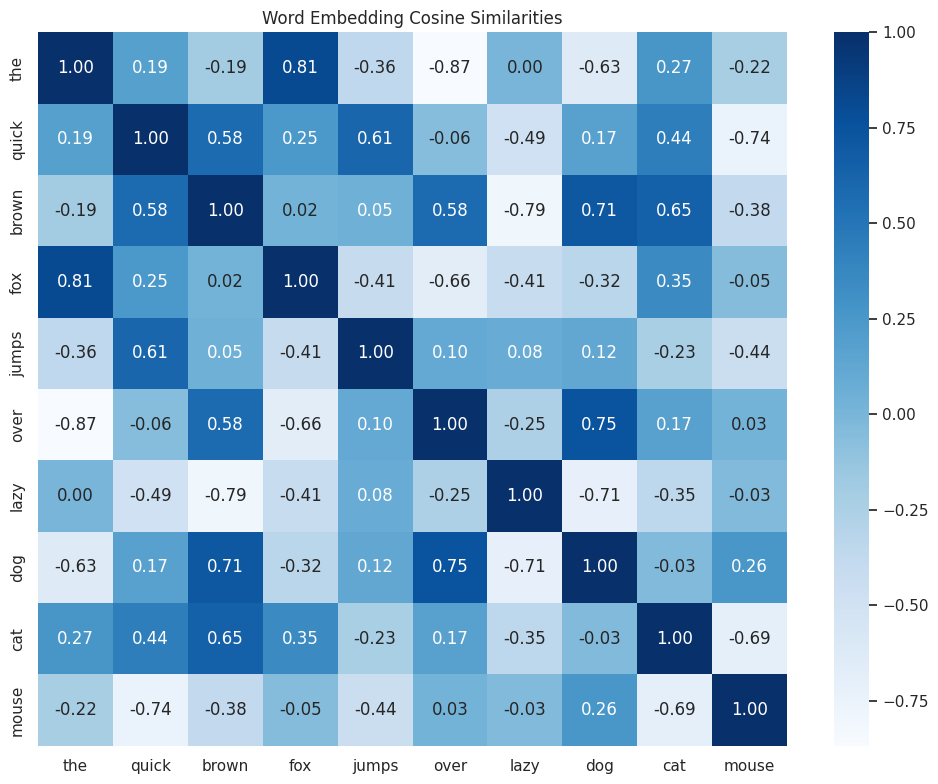

In [13]:
# Create a small vocabulary with 10 words and 5-dimensional embeddings
vocabulary = ["the", "quick", "brown", "fox", "jumps", "over", "lazy", "dog", "cat", "mouse"]
vocab_size = len(vocabulary)
embedding_dim = 5

# Generate random word embeddings (in practice, these would be learned)
word_embeddings = torch.randn(vocab_size, embedding_dim)

# Create a dictionary mapping words to their embeddings
word_to_idx = {word: i for i, word in enumerate(vocabulary)}
word_to_embedding = {word: word_embeddings[i] for word, i in word_to_idx.items()}

# Compute cosine similarity between all pairs of words
# First normalize all embeddings
normalized_embeddings = word_embeddings / torch.norm(word_embeddings, dim=1, keepdim=True)

# Compute all pairwise dot products using einsum
# This gives us the cosine similarity since vectors are normalized
similarity_matrix = torch.einsum('ie,je->ij', normalized_embeddings, normalized_embeddings)

# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.detach().numpy(), annot=True, cmap='Blues', fmt=".2f",
            xticklabels=vocabulary, yticklabels=vocabulary)
plt.title('Word Embedding Cosine Similarities')
plt.tight_layout()
plt.show()


### Word Context Prediction

Let's simulate a simple word2vec-like model that predicts context words given a center word:


Word context prediction probabilities:
the → quick: 0.718
the → brown: 0.341
quick → the: 0.718
quick → brown: 0.899
quick → fox: 0.714
brown → the: 0.341
brown → quick: 0.899
brown → fox: 0.515
brown → jumps: 0.521
fox → quick: 0.714
fox → brown: 0.515
fox → jumps: 0.327
fox → over: 0.052
jumps → brown: 0.521
jumps → fox: 0.327
jumps → over: 0.580
jumps → the: 0.297
over → fox: 0.052
over → jumps: 0.580
over → the: 0.006
over → lazy: 0.164
the → jumps: 0.297
the → over: 0.006
the → lazy: 0.506
the → dog: 0.046
lazy → over: 0.164
lazy → the: 0.506
lazy → dog: 0.023
dog → the: 0.046
dog → lazy: 0.023


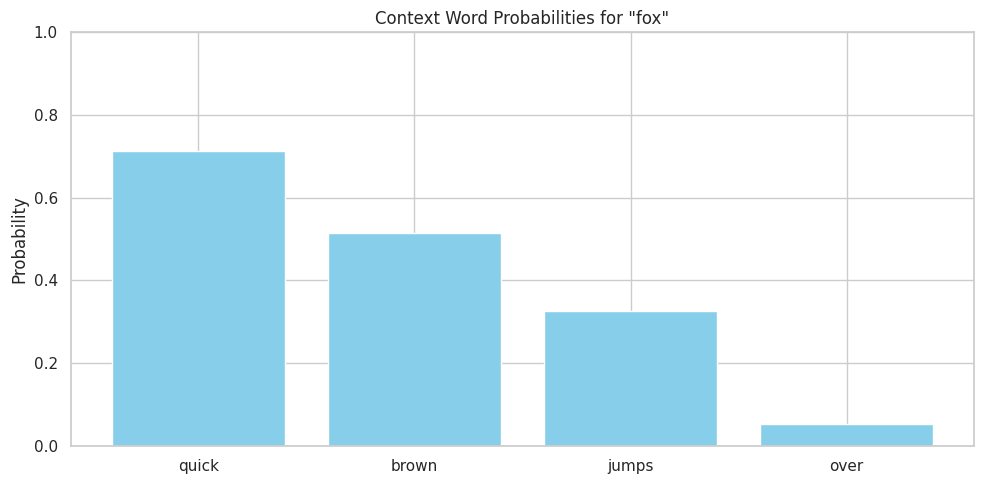

In [14]:
# Create a simple sentence for context
sentence = ["the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]

# Create context pairs (center word, context word)
window_size = 2
context_pairs = []

for i in range(len(sentence)):
    center_word = sentence[i]
    for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
        if i != j:  # Skip the center word itself
            context_word = sentence[j]
            context_pairs.append((center_word, context_word))

# Convert words to indices
context_indices = [(word_to_idx[center], word_to_idx[context]) 
                  for center, context in context_pairs 
                  if center in word_to_idx and context in word_to_idx]

# Prepare data for batch processing
center_indices = torch.tensor([center for center, _ in context_indices])
context_indices = torch.tensor([context for _, context in context_indices])

# Lookup embeddings
center_embeddings = word_embeddings[center_indices]
context_embeddings = word_embeddings[context_indices]

# Compute dot products between center and context words
# This simulates the prediction scores in skip-gram model
dot_products = torch.einsum('be,be->b', center_embeddings, context_embeddings)

# Convert to probabilities using sigmoid
probabilities = torch.sigmoid(dot_products)

# Show results
result_data = {
    'Center Word': [vocabulary[idx.item()] for idx in center_indices],
    'Context Word': [vocabulary[idx.item()] for idx in context_indices],
    'Probability': probabilities.detach().numpy()
}

print("Word context prediction probabilities:")
for i in range(len(result_data['Center Word'])):
    print(f"{result_data['Center Word'][i]} → {result_data['Context Word'][i]}: {result_data['Probability'][i]:.3f}")

# Plot probabilities for a specific center word
center_word = "fox"
if center_word in word_to_idx:
    center_idx = word_to_idx[center_word]
    mask = center_indices == center_idx
    
    if torch.any(mask):
        plt.figure(figsize=(10, 5))
        context_words = [vocabulary[idx.item()] for idx in context_indices[mask]]
        probs = probabilities[mask].detach().numpy()
        
        plt.bar(context_words, probs, color='skyblue')
        plt.title(f'Context Word Probabilities for "{center_word}"')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()


## Summary

In this notebook, we've explored practical applications of tensor operations and Einstein notation across different domains:

1. **Machine Learning**: We implemented neural network layers including multi-head attention.

2. **Computer Graphics**: We performed 3D transformations and perspective projection.

3. **Physics**: We calculated the moment of inertia tensor for a system of point masses.

4. **Signal Processing**: We implemented image filtering operations using convolution.

5. **Natural Language Processing**: We worked with word embeddings and context prediction.

These examples demonstrate how tensor operations and Einstein notation provide a powerful and concise framework for expressing complex computations across diverse fields. By understanding these fundamental operations, you can develop intuition for working with higher-dimensional data in any domain.

The ability to clearly express operations on tensors is essential for modern computational science, and Einstein notation provides a compact, readable syntax for these operations. As data becomes increasingly high-dimensional, these tools become even more valuable.